In [ ]:
#date: 2025-04-23
#author: Junjie Yang

# !pip install statannotations

#generate plots for the demographic analysis
#import peak area
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import tabulate

from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
#demographic data
#prepare demographic data
sample_name = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/sample_id_serum_clean.csv")
demogra_data = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/Demoographics_fmt_copy.csv")

# Clean and classify demographic data
demogra_data['ga_weeks_mr'] = pd.to_numeric(demogra_data['ga_weeks_mr'], errors='coerce')

demogra_data['Terms'] = np.where(
    demogra_data['ga_weeks_mr'].isna(), 
    np.nan, 
    np.where(demogra_data['ga_weeks_mr'] < 37, 'preterm', 'full_term')
)

demogra_data['GDM_diag'] = demogra_data['gstdiab_mr'].map({
    "1, Yes": "GDM",
    "0, No": "Non-GDM",
    ".": np.nan
})

demogra_data['Edu'] = demogra_data['edu_m_pre_cv'].map({
    "5, Graduate Degree": "Post_grad",
    "4, Bachelor's Degree": "College",
    "3, Some College or AA Degree": "College",
    "1, <High School": "Highschool/less",
    "2, HS Degree or GED": "Highschool/less",
    ".": np.nan,
    "": np.nan
})

demogra_data['Race'] = demogra_data['race_m_cv'].map({
    '1, White': 'NH-White',
    '2, Black or African American': 'NH-Black',
    '3, Asian': 'NH-Asian',
    '4, Native Hawaiian or Other Pacific Islander': 'other',
    '5, American Indian or Alaska Native': 'other',
    '6, More than 1 race': 'other',
    '-8, Unknown, Not Reported or Other': 'other',
    'hispanic': 'Latina'
})

demogra_data['Nativity'] = demogra_data['usborn_m_cv'].map({
    '1, US Born': 'US',
    '0, Foreign Born': 'other',
    '.': 'other'
})

demogra_data['Smoke'] = demogra_data['smoke_cv'].map({
    '2, Former smoker': 'smoke',
    '1, Never smoked': 'non-smoke',
    '.': np.nan
})

demogra_data['Hypertension'] = demogra_data['htn_prg_mr'].map({
    '0, No': 'non-hypertension',
    '1, Yes': 'hypertension',
    '.': np.nan
})

# Convert ppt_id to string and reorder columns
demogra_data['ppt_id'] = demogra_data['ppt_id'].astype(str)
cols = ['ppt_id', 'Terms', 'GDM_diag', 'Edu'] + [col for col in demogra_data.columns if col not in ['ppt_id', 'Terms', 'GDM_diag', 'Edu']]
demogra_data = demogra_data[cols]

In [107]:
demogra_datacopy = demogra_data.copy()
demogra_datacopy = demogra_datacopy[['ppt_id','GDM_diag', 'Edu', 'age_dlvry_mr','ga_weeks_mr','Hypertension', 'Smoke','Nativity','Race']]

In [173]:
#pca batched corrected data
#extract BC data from netargeted and postargeted
neg_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Neg_PCA_batchcorrected_data.csv'
pos_peak_area = 'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Pos_PCA_batchcorrected_data.csv'

#create feature_id column by combining column Average Rt(min) and Average m/z: Average Rt(min) + '_' + Average m/z
neg_peak_area = pd.read_csv(neg_peak_area)
pos_peak_area = pd.read_csv(pos_peak_area)

#level 2 and level 1 features 
postarget7 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/library_search_res_pos_level1andlevel2.csv')
postarget7['feature_id'] = postarget7['Average Rt(min)'].astype(str) + "_" + postarget7['Average Mz'].astype(str)
negtarget7 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/library_search_res_neg_level1andlevel2.csv')
negtarget7['feature_id'] = negtarget7['Average Rt(min)'].astype(str) + "_" + negtarget7['Average Mz'].astype(str)


# ========== 3. Process Negative Peak Area ==========
neg_data = neg_peak_area.iloc[:, 1:].copy()
clean_names = neg_data.columns.str.extract(r'BH(\d{5})')[0]
neg_data.columns = clean_names
neg_data = neg_data.apply(pd.to_numeric, errors='coerce')

# Average replicates
neg_avg = neg_data.groupby(level=0, axis=1).mean()

# Rename columns to match sample_name identifiers
new_names = sample_name['RO1 REVEAL Sample number'].dropna().astype(int).astype(str).unique().tolist()
neg_avg.columns = new_names
neg_avg['feature_id'] = neg_peak_area['feature_id']

#Separate out 'peak_id'
cols_to_transform = [col for col in neg_avg.columns if col != 'feature_id']
neg_avg[cols_to_transform] = np.log2(neg_avg[cols_to_transform])

#subsetting rows accroding to the feature_id in the negtarget7
neg_avg = neg_avg[neg_avg['feature_id'].isin(negtarget7['feature_id'])]


# ========== 4. Statistical Testing ==========
# Reshape to long format
neg_long = neg_avg.melt(id_vars='feature_id', var_name='ppt_id', value_name='peak_area')
neg_long = neg_long.merge(demogra_data, on='ppt_id', how='left')

demographic_vars = ["Terms", "GDM_diag", "Edu", "Race", "Nativity","Hypertension"]
# demographic_vars = ["Terms", "GDM_diag", "Edu", "Race", "Nativity"]
# demographic_vars = ["Terms", "GDM_diag", "Hypertension"]
# results = []

# for var in demographic_vars:
#     filtered = neg_long.dropna(subset=[var])
#     for pid, subdf in filtered.groupby('feature_id'):
#         groups = [grp['peak_area'].dropna().values for _, grp in subdf.groupby(var)]
#         if len(groups) > 1 and all(len(g) > 0 for g in groups):
#             stat, p = kruskal(*groups)
#             results.append({'feature_id': pid, 'variable': var, 'p_value': p})

# # Compile results
# res_df = pd.DataFrame(results)
# print(f"Total tests performed: {len(res_df)}")

# if not res_df.empty and 'p_value' in res_df.columns:
#     res_df['adj_p_value'] = multipletests(res_df['p_value'], method='fdr_bh')[1]
#     # significant = res_df[res_df['p_value'] < 0.05]
#     significant = res_df[res_df['adj_p_value'] < 0.05]
#     print(f"Significant features (p < 0.05): {len(significant)}")
# else:
#     print("No valid p-values found for correction.")
#     res_df['adj_p_value'] = np.nan
#     significant = pd.DataFrame()

# targetmz_path = ["D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/plastic_map_chemlist/Plastic_Chemical_withRT_CFMID_spectrumdatabase_chemical_annotation_20250404.csv"] #plastic chemical list with predicted/library RT, CRMID, and spectrum ID match record,
# plastics_chem = pd.read_csv(targetmz_path[0])

# #merge DTXSID and PREFERERED_NAME to the significant features according to feature_id
# sig_features = pd.merge(significant, negtarget7[['feature_id', 'DTXSID', 'PREFERRED_NAME','annotation_level','Total_production']], on='feature_id', how='left')
# sig_features = pd.merge(sig_features, plastics_chem[['DTXSID', 'DATA_SOURCES']], on='DTXSID', how='left')
# sig_features = sig_features[['feature_id', 'DTXSID', 'PREFERRED_NAME','DATA_SOURCES', 'Total_production', 'annotation_level', 'variable', 'p_value', 'adj_p_value']]
# print(f"Total significant features: {len(sig_features)}")
# print(tabulate.tabulate(sig_features, headers='keys', tablefmt='psql', showindex=False))

# # #export the significant features
# sig_features.to_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_mode_plots/significant_features.csv', index=False)

results = []

for var in demographic_vars:
    filtered = neg_long.dropna(subset=[var])
    for pid, subdf in filtered.groupby('feature_id'):
        # 1) Group by the demographic variable, keep only non‐NA peak_area
        grp_by = subdf.groupby(var)
        # 2) Identify levels that actually have data
        levels = [lvl for lvl, grp in grp_by if grp['peak_area'].notna().any()]
        if len(levels) < 2:
            continue

        # 3) Extract arrays for Kruskal–Wallis
        arrays = [grp_by.get_group(lvl)['peak_area'].dropna().values for lvl in levels]
        stat, p = kruskal(*arrays)

        # 4) Compute fold‑change between the first two levels
        med1, med2 = np.mean(arrays[0]), np.mean(arrays[1])
        log2fc = med2 - med1
        fc = 2 ** log2fc

        results.append({
            'feature_id': pid,
            'variable':   var,
            'p_value':    p,
            'fold_change': fc,
            'log2_foldchange': log2fc
        })

# Compile into DataFrame
res_df = pd.DataFrame(results)
print(f"Total tests performed: {len(res_df)}")

# Multiple testing correction
if not res_df.empty:
    res_df['adj_p_value'] = multipletests(res_df['p_value'], method='fdr_bh')[1]
    significant = res_df[res_df['adj_p_value'] < 0.05].copy()
    print(f"Significant features (adj p < 0.05): {len(significant)}")
else:
    res_df['adj_p_value'] = np.nan
    significant = pd.DataFrame()

# Merge annotations and export
sig_features = (
    significant
    .merge(negtarget7[['feature_id','DTXSID','PREFERRED_NAME','annotation_level','Total_production']],
           on='feature_id', how='left')
    .merge(plastics_chem[['DTXSID','DATA_SOURCES']], on='DTXSID', how='left')
    [['feature_id','DTXSID','PREFERRED_NAME','DATA_SOURCES','Total_production',
      'annotation_level','variable','p_value','adj_p_value','fold_change', 'log2_foldchange']]
)

print(f"Total significant features: {len(sig_features)}")
sig_features.to_csv(
    'D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots/significant_features_with_FC.csv',
    index=False
)


Total tests performed: 1476
Significant features (adj p < 0.05): 142
Total significant features: 295


In [ ]:
# from statannotations.Annotator import Annotator
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import numpy as np

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

# # ——— Setup output folder ———
# plot_dir = r"D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_mode_plots"
# os.makedirs(plot_dir, exist_ok=True)

# # ——— Settings ———
# plots_per_row = 4

# # ——— Define comparisons ———
# comparison_dict = {
#     'Terms': [('full_term', 'preterm')],
#     'GDM_diag': [('Non-GDM', 'GDM')],
#     'Edu': [
#         ('Highschool/less','College'),
#         ('Highschool/less', 'Post_grad'),
#         ('College', 'Post_grad')
#     ],
#     'Nativity': [('US', 'other')],
#     'Race': [
#         ('other', 'Latina'), ('other', 'NH-Black'), ('other', 'NH-White'), ('other', 'NH-Asian'),
#         ('Latina', 'NH-Black'), ('Latina', 'NH-White'), ('Latina', 'NH-Asian'),
#         ('NH-White', 'NH-Black'), ('NH-White', 'NH-Asian'), ('NH-Black', 'NH-Asian')
#     ],
#     'Hypertension' : [('non-hypertension','hypertension')]
# }

# # ——— Define Edu order ———
# edu_order = ['Highschool/less', 'College', 'Post_grad']

# plot_dir = r"D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_mode_plots"
# os.makedirs(plot_dir, exist_ok=True)

# # ——— Settings ———
# plots_per_row = 4

# # ——— Define comparisons ———
# comparison_dict = {
#     'Terms': [('full_term', 'preterm')],
#     'GDM_diag': [('Non-GDM', 'GDM')],
#     'Edu': [
#         ('Highschool/less','College'),
#         ('Highschool/less', 'Post_grad'),
#         ('College', 'Post_grad')
#     ],
#     'Nativity': [('US', 'other')],
#     'Race': [
#         ('other', 'Latina'), ('other', 'NH-Black'),
#         ('other', 'NH-White'), ('other', 'NH-Asian'),
#         ('Latina', 'NH-Black'), ('Latina', 'NH-White'),
#         ('Latina', 'NH-Asian'), ('NH-White', 'NH-Black'),
#         ('NH-White', 'NH-Asian'), ('NH-Black', 'NH-Asian')
#     ],
#     'Hypertension': [('non-hypertension', 'hypertension')]
# }

# # ——— Define Edu order ———
# edu_order = ['Highschool/less', 'College', 'Post_grad']

# for var in demographic_vars:
#     if var not in comparison_dict:
#         print(f"No comparisons defined for {var}. Skipping...")
#         continue

#     # find features significant for this variable
#     peaks = significant.loc[
#         significant['variable'] == var, 'feature_id'
#     ].unique()
#     if len(peaks) == 0:
#         print(f"No significant peaks for variable: {var}")
#         continue

#     # Cast Edu to ordered categorical for consistent ordering
#     if var == 'Edu':
#         neg_long[var] = pd.Categorical(
#             neg_long[var],
#             categories=edu_order,
#             ordered=True
#         )

#     # Setup combined-figure grid
#     n_rows = (len(peaks) + plots_per_row - 1) // plots_per_row
#     fig, axs = plt.subplots(
#         n_rows, plots_per_row,
#         figsize=(plots_per_row * 5, n_rows * 5)
#     )
#     axs = axs.flatten()

#     for i, pid in enumerate(peaks):
#         plot_data = neg_long[
#             (neg_long['feature_id'] == pid) &
#             (~neg_long[var].isna())
#         ]
#         if plot_data.empty:
#             continue

#         # Fetch raw and adjusted p-values, cast to float
#         sig_row = significant.query(
#             "feature_id == @pid and variable == @var"
#         ).iloc[0]
#         p_val     = float(sig_row['p_value'])
#         adj_p_val = float(sig_row['adj_p_value'])

#         # ——— Box + strip on combined figure ———
#         ax = axs[i]
#         sns.boxplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             palette="Set3",
#             order=edu_order if var == 'Edu' else None,
#             ax=ax,
#             legend=False
#         )
#         sns.stripplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             order=edu_order if var == 'Edu' else None,
#             color='black', jitter=True, alpha=0.6, ax=ax
#         )

#         # —— Annotator using adjusted p-values and explicit thresholds ——  
#         annotator = Annotator(
#             ax, comparison_dict[var],
#             data=plot_data, x=var, y="peak_area",
#             order=edu_order if var == 'Edu' else None
#         )
#         annotator.configure(
#             test=None,
#             text_format='star',
#             loc='inside',
#             verbose=0,
#             pvalue_thresholds=[
#                 (0.001, '***'),
#                 (0.01,  '**'),
#                 (0.05,  '*')    # no star if adj-p > 0.05
#             ]
#         )
#         annotator.set_pvalues_and_annotate(
#             [adj_p_val] * len(comparison_dict[var])
#         )

#         ax.set_title(
#             f"{pid}\nraw p={p_val:.2e} | adj p={adj_p_val:.2e}",
#             fontsize=10
#         )
#         ax.set_ylabel("Log2 Peak Area")
#         ax.set_xlabel(var)
#         ax.grid(axis='y', linestyle='--', alpha=0.7)
#         ax.tick_params(axis='x', rotation=45)

#         # ——— Save individual plot ———
#         fig_single, ax_single = plt.subplots(figsize=(6, 5))
#         sns.boxplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             palette="Set3",
#             order=edu_order if var == 'Edu' else None,
#             ax=ax_single
#         )
#         sns.stripplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             order=edu_order if var == 'Edu' else None,
#             color='black', jitter=True, alpha=0.6, ax=ax_single
#         )
#         ax_single.set_title(
#             f"{pid}\nraw p={p_val:.2e} | adj p={adj_p_val:.2e}",
#             fontsize=12
#         )
#         ax_single.tick_params(axis='x', rotation=45)
#         fig_single.tight_layout()

#         single_path = os.path.join(
#             plot_dir,
#             f"boxplot_{var}_{pid}.tif"
#         )
#         fig_single.savefig(single_path, dpi=300)
#         plt.close(fig_single)

#     # Remove empty subplots
#     for j in range(i + 1, len(axs)):
#         fig.delaxes(axs[j])

#     fig.tight_layout()
#     combined_path = os.path.join(
#         plot_dir,
#         f"combined_{var}.tif"
#     )
#     fig.savefig(combined_path, dpi=300)
#     plt.close(fig)

#     print(f"Saved combined and individual plots for variable: {var}")

No significant peaks for variable: Terms
Saved combined and individual plots for variable: GDM_diag
Saved combined and individual plots for variable: Edu
Saved combined and individual plots for variable: Race
Saved combined and individual plots for variable: Nativity
Saved combined and individual plots for variable: Hypertension


In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# ——— Define comparisons ———
comparison_dict = {
    'Terms': [('full_term', 'preterm')],
    'GDM_diag': [('Non-GDM', 'GDM')],
    'Edu': [
        ('Highschool/less','College'),
        ('Highschool/less', 'Post_grad'),
        ('College', 'Post_grad')
    ],
    'Nativity': [('US', 'other')],
    'Race': [
        ('other', 'Latina'), ('other', 'NH-Black'), ('other', 'NH-White'), ('other', 'NH-Asian'),
        ('Latina', 'NH-Black'), ('Latina', 'NH-White'), ('Latina', 'NH-Asian'),
        ('NH-White', 'NH-Black'), ('NH-White', 'NH-Asian'), ('NH-Black', 'NH-Asian')
    ],
    'Hypertension' : [('non-hypertension','hypertension')]
}

# ——— Define Edu order ———
edu_order = ['Highschool/less', 'College', 'Post_grad']

# plot_dir = r"D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_mode_plots"
# os.makedirs(plot_dir, exist_ok=True)

# # ——— Settings ———
# plots_per_row = 4

# # ——— Define your comparisons and ordering as before ———
# comparison_dict = {
#     'Terms':         [('full_term', 'preterm')],
#     'GDM_diag':      [('Non-GDM',    'GDM')],
#     'Edu': [
#         ('Highschool/less', 'College'),
#         ('Highschool/less', 'Post_grad'),
#         ('College',          'Post_grad')
#     ],
#     'Nativity':      [('US', 'other')],
#     'Race': [
#         ('other',   'Latina'),    ('other',   'NH-Black'),
#         ('other',   'NH-White'),  ('other',   'NH-Asian'),
#         ('Latina',  'NH-Black'),  ('Latina',  'NH-White'),
#         ('Latina',  'NH-Asian'),  ('NH-White','NH-Black'),
#         ('NH-White','NH-Asian'),  ('NH-Black','NH-Asian')
#     ],
#     'Hypertension': [('non-hypertension', 'hypertension')]
# }
# edu_order = ['Highschool/less', 'College', 'Post_grad']

# for var in demographic_vars:
#     if var not in comparison_dict:
#         print(f"No comparisons defined for {var}. Skipping...")
#         continue

#     # find significant features
#     peaks = significant.loc[
#         significant['variable']==var, 'feature_id'
#     ].unique()
#     if len(peaks) == 0:
#         print(f"No significant peaks for variable: {var}")
#         continue

#     # for Edu, enforce order
#     if var == 'Edu':
#         neg_long[var] = pd.Categorical(
#             neg_long[var], categories=edu_order, ordered=True
#         )

#     # how many rows of subplots?
#     n_rows = (len(peaks) + plots_per_row - 1) // plots_per_row
#     fig, axs = plt.subplots(
#         n_rows, plots_per_row,
#         figsize=(plots_per_row * 5, n_rows * 5),
#         squeeze=False
#     )
#     axs = axs.flatten()

#     for i, pid in enumerate(peaks):
#         plot_data = neg_long[
#             (neg_long['feature_id']==pid) &
#             (~neg_long[var].isna())
#         ]
#         if plot_data.empty:
#             continue

#         # grab p‑values
#         row = significant.query(
#             "feature_id==@pid and variable==@var"
#         ).iloc[0]
#         adj_p = float(row['adj_p_value'])

#         ax = axs[i]
#         sns.boxplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             palette="Set3",
#             order=edu_order if var=='Edu' else None,
#             ax=ax
#         )
#         sns.stripplot(
#             x=var, y="peak_area",
#             data=plot_data,
#             order=edu_order if var=='Edu' else None,
#             color='black', jitter=True, alpha=0.6, ax=ax
#         )

#         # annotate stars for adj_p < thresholds
#         annot = Annotator(
#             ax, comparison_dict[var],
#             data=plot_data, x=var, y="peak_area",
#             order=edu_order if var=='Edu' else None
#         )
#         annot.configure(
#             test=None,
#             text_format='star',
#             loc='inside',
#             verbose=0,
#             pvalue_thresholds=[
#                 (0.05, '*'),
#                 (0.01, '**'),
#                 (0.001, '***')
#             ]
#         )
#         annot.set_pvalues([adj_p] * len(comparison_dict[var]))
#         annot.annotate()

#         ax.set_title(f"{pid}\nadj p={adj_p:.2e}", fontsize=12)
#         ax.set_xlabel(var)
#         ax.set_ylabel("Log2 Peak Area")
#         ax.tick_params(axis='x', rotation=45)
#         ax.grid(axis='y', linestyle='--', alpha=0.7)

#     # remove any unused axes
#     for j in range(i+1, len(axs)):
#         fig.delaxes(axs[j])

#     # fig.tight_layout()
#     # plt.show()

#         # --- SAVE instead of plt.show() ---
#     out_path = os.path.join(plot_dir, f"boxplots_{var}.png")
#     fig.savefig(out_path, dpi=300)
#     plt.close(fig)

#     print(f"Saved figure for {var} to {out_path}")


import os
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

plot_dir = r"D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
os.makedirs(plot_dir, exist_ok=True)

plots_per_row = 4

for var in demographic_vars:
    peaks = significant.loc[significant['variable']==var, 'feature_id'].unique()
    if len(peaks)==0: 
        continue

    # prepare ordering
    if var=='Edu':
        neg_long[var] = pd.Categorical(neg_long[var], categories=edu_order, ordered=True)

    # --- Combined grid (optional) ---
    n_rows = (len(peaks)+plots_per_row-1)//plots_per_row
    fig, axs = plt.subplots(n_rows, plots_per_row,
                             figsize=(plots_per_row*4, n_rows*4),
                             squeeze=False)
    axs = axs.flatten()

    for i, pid in enumerate(peaks):
        plot_data = neg_long[(neg_long['feature_id']==pid)&(~neg_long[var].isna())]
        if plot_data.empty:
            continue

        adj_p = float(significant.query("feature_id==@pid and variable==@var")['adj_p_value'])

        # Combined grid plot
        ax = axs[i]
        sns.boxplot(x=var, y="peak_area", data=plot_data,
                    palette="Set3",
                    order=edu_order if var=='Edu' else None,
                    ax=ax)
        sns.stripplot(x=var, y="peak_area", data=plot_data,
                      order=edu_order if var=='Edu' else None,
                      color='black', jitter=True, alpha=0.6, ax=ax)
        annot = Annotator(ax, comparison_dict[var],
                          data=plot_data, x=var, y="peak_area",
                          order=edu_order if var=='Edu' else None)
        annot.configure(test=None, text_format='star', loc='inside',
                        pvalue_thresholds=[(0.05,'*'),(0.01,'**'),(0.001,'***')])
        annot.set_pvalues([adj_p]*len(comparison_dict[var]))
        annot.annotate()
        ax.set_title(f"{pid}\nadj p={adj_p:.2e}")
        ax.tick_params(axis='x', rotation=45)

        # --- Individual plot ---
        fig_single, ax_single = plt.subplots(figsize=(5,4))
        sns.boxplot(x=var, y="peak_area", data=plot_data,
                    palette="Set3",
                    order=edu_order if var=='Edu' else None,
                    ax=ax_single)
        sns.stripplot(x=var, y="peak_area", data=plot_data,
                      order=edu_order if var=='Edu' else None,
                      color='black', jitter=True, alpha=0.6, ax=ax_single)
        annot_single = Annotator(ax_single, comparison_dict[var],
                                 data=plot_data, x=var, y="peak_area",
                                 order=edu_order if var=='Edu' else None)
        annot_single.configure(test=None, text_format='star', loc='inside',
                               pvalue_thresholds=[(0.05,'*'),(0.01,'**'),(0.001,'***')])
        annot_single.set_pvalues([adj_p]*len(comparison_dict[var]))
        annot_single.annotate()
        ax_single.set_title(f"{pid}\nadj p={adj_p:.2e}")
        ax_single.tick_params(axis='x', rotation=45)
        ax_single.set_ylabel("Log2 Peak Area")

        # Save individual
        single_path = os.path.join(plot_dir, f"{var}_{pid}.png")
        fig_single.tight_layout()
        fig_single.savefig(single_path, dpi=300)
        plt.close(fig_single)

    # tidy up combined grid
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    fig.tight_layout()
    combined_path = os.path.join(plot_dir, f"combined_{var}.png")
    fig.savefig(combined_path, dpi=300)
    plt.close(fig)

    print(f"Saved individual plots for {var} and combined at {combined_path}")


p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Non-GDM vs. GDM: Custom statistical test, P_val:2.874e-02
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Non-GDM vs. GDM: Custom statistical test, P_val:2.874e-02
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Non-GDM vs. GDM: Custom statistical test, P_val:4.325e-02
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Non-GDM vs. GDM: Custom statistical test, P_val:4.325e-02
Saved individual plots for GDM_diag and combined at D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots\combined_GDM_diag.png
p-value annotation legend:
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***:

In [16]:
#FOR positive data
# ========== 3. Process positive Peak Area ==========
pos_data = pos_peak_area.iloc[:, 1:].copy()
clean_names = pos_data.columns.str.extract(r'BH(\d{5})')[0]
pos_data.columns = clean_names
pos_data = pos_data.apply(pd.to_numeric, errors='coerce')

# Average replicates
pos_avg = pos_data.groupby(level=0, axis=1).mean()

# Rename columns to match sample_name identifiers
new_names = sample_name['RO1 REVEAL Sample number'].dropna().astype(int).astype(str).unique().tolist()
pos_avg.columns = new_names
pos_avg['feature_id'] = pos_peak_area['feature_id']

#Separate out 'feature_id'
cols_to_transform = [col for col in pos_avg.columns if col != 'feature_id']
pos_avg[cols_to_transform] = np.log2(pos_avg[cols_to_transform])

# Impute NA with min in each row
pos_avg[cols_to_transform] = pos_avg[cols_to_transform].apply(
    lambda row: row.fillna(row.min()) if not row.isna().all() else row, axis=1)

#subsetting rows accroding to the feature_id in the negtarget7
pos_avg = pos_avg[pos_avg['feature_id'].isin(postarget7['feature_id'])]


# ========== 4. Statistical Testing ==========
# Reshape to long format
pos_long = pos_avg.melt(id_vars='feature_id', var_name='ppt_id', value_name='peak_area')
pos_long = pos_long.merge(demogra_data, on='ppt_id', how='left')

demographic_vars = ["Terms", "GDM_diag", "Edu", "Race", "Nativity"]
results = []


for var in demographic_vars:
    filtered = pos_long.dropna(subset=[var])
    for pid, subdf in filtered.groupby('feature_id'):
        groups = [grp['peak_area'].dropna().values for _, grp in subdf.groupby(var)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            stat, p = kruskal(*groups)
            results.append({'feature_id': pid, 'variable': var, 'p_value': p})

# Compile results
res_df = pd.DataFrame(results)
print(f"Total tests performed: {len(res_df)}")

if not res_df.empty and 'p_value' in res_df.columns:
    res_df['adj_p_value'] = multipletests(res_df['p_value'], method='fdr_bh')[1]
    # significant = res_df[res_df['p_value'] < 0.05]
    significant = res_df[res_df['adj_p_value'] < 0.05]
    print(f"Significant features (p < 0.05): {len(significant)}")
else:
    print("No valid p-values found for correction.")
    res_df['adj_p_value'] = np.nan
    significant = pd.DataFrame()

Total tests performed: 570
Significant features (p < 0.05): 0


In [136]:
print(neg_avg.head(5))

           842        135        830        797        534        259  \
21   14.972628  15.642658  17.714541  16.681531  15.376302  15.485419   
325  12.444780  12.592517  12.576254  12.727251  12.651741  12.598537   
330  12.506477  12.551860  13.277623  12.934261  12.412719  12.569827   
345  15.321595  15.606424  16.259432  16.415548  15.519135  15.421901   
353  14.282298  14.423617  15.406344  15.284463  14.695835  14.144699   

           700        652        685        754  ...        866        438  \
21   16.559127  16.291444  16.066809  16.453799  ...  18.716362  17.840869   
325  12.529331  12.620205  12.684909  12.910319  ...  13.087212  12.790818   
330  12.942353  12.816608  12.745213  12.663058  ...  13.511777  14.001039   
345  15.950678  15.950822  16.219122  16.908209  ...  16.897465  15.797397   
353  15.369636  15.177073  15.095570  16.283880  ...  16.716001  14.802124   

           101        364        489        369        697        703  \
21   18.656089  18.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

#-----------------------------------------------------PCA loading analysis of Education level

# 1) Load your averaged peak area (features × samples) and demographics
dem = demogra_data.copy()

# # Filter to those features significant for Edu
# edu_feats = sig_features.loc[sig_features['variable']=='Edu', 'feature_id'].unique()
# neg_sub = neg_avg[neg_avg['feature_id'].isin(edu_feats)].copy()

# # 2) Transpose: we want samples as rows, features as columns
# #    Drop the 'feature_id' column, transpose, and restore sample IDs
# mat = neg_sub.set_index('feature_id').T
# mat.index.name = 'ppt_id'
# mat.reset_index(inplace=True)

# # 3) Merge in Edu from dem
# dem_clean = dem[['ppt_id','Edu']].dropna(subset=['Edu']).copy()
# dem_clean['ppt_id'] = dem_clean['ppt_id'].astype(mat['ppt_id'].dtype)
# df = mat.merge(dem_clean, on='ppt_id', how='inner')

# # 4) Prepare data for PCA: features only, scaled
# feature_cols = [c for c in df.columns if c not in ['ppt_id','Edu']]
# X = df[feature_cols].values
# Xz = StandardScaler().fit_transform(X)

# # 5) PCA
# pca = PCA(n_components=2)
# pcs = pca.fit_transform(Xz)
# pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
# pc_df['Edu'] = df['Edu'].values

# # 6) t‐test on PC1 by Edu groups
# group1 = pc_df.loc[pc_df['Edu']=='Highschool/less','PC1']
# group2 = pc_df.loc[pc_df['Edu'].isin(['College']),'PC1']
# group3 = pc_df.loc[pc_df['Edu']=='Post_grad','PC1'] 

# # Alternatively compare College vs Post_grad separately if desired
# tstat, pval = ttest_ind(group1, group2, nan_policy='omit')
# tstat2, pval2 = ttest_ind(group1, group3, nan_policy='omit')
# tstat3, pval3 = ttest_ind(group2, group3, nan_policy='omit')
# print(f'testgroup1_grp2: {(tstat, pval)}')
# print(f'testgroup1_grp3: {(tstat2, pval2)}')
# print(f'testgroup2_grp3: {(tstat3, pval3)}') 


# # 7) Plot boxplot of PC1 by Edu
# plt.figure(figsize=(6,5))
# ax = sns.boxplot(x='Edu', y='PC1', data=pc_df, palette='Set2', order=['Highschool/less','College','Post_grad'])
# sns.stripplot(x='Edu', y='PC1', data=pc_df, color='black', size=4, jitter=0.2, ax=ax)

# # annotate p‐value between Highschool/less vs (College+Post_grad)
# ymax = pc_df['PC1'].max()
# ymin = pc_df['PC1'].min()
# y = ymax + 0.1*(ymax-ymin)
# # ax.plot([0, 1], [y,y], color='black')
# # ax.text(0.5, y+0.02*(ymax-ymin), sig_text, ha='center', va='bottom', fontsize=14)

# ax.set_title('PC1 Scores by Education Level')
# ax.set_xlabel('Education')
# ax.set_ylabel('PC1 Score')
# plt.tight_layout()
# # plt.show()
# # print(f"t‐test Highschool vs College/Postgrad: t={tstat:.2f}, p={pval:.3g}")

# # --- 10) Save figure ---
# output_dir = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
# os.makedirs(output_dir, exist_ok=True)
# fig_path = os.path.join(output_dir, "PCA_PC1_Edu.tiff")
# plt.savefig(fig_path, dpi=300)
# plt.close()
# print(f"Saved PCA boxplot to {fig_path}")


#-----------------------------------------------------------------------PCA loading analysis of GDM diagnosis
# Filter to those features significant 
# GDM_feats = sig_features.loc[sig_features['variable']=='GDM_diag', 'feature_id'].unique()
# neg_sub = neg_avg[neg_avg['feature_id'].isin(GDM_feats)].copy()

# # 2) Transpose: we want samples as rows, features as columns
# #    Drop the 'feature_id' column, transpose, and restore sample IDs
# mat = neg_sub.set_index('feature_id').T
# mat.index.name = 'ppt_id'
# mat.reset_index(inplace=True)

# # 3) Merge in from dem
# dem_clean = dem[['ppt_id','GDM_diag']].dropna(subset=['GDM_diag']).copy()
# dem_clean['ppt_id'] = dem_clean['ppt_id'].astype(mat['ppt_id'].dtype)
# df = mat.merge(dem_clean, on='ppt_id', how='inner')

# # 4) Prepare data for PCA: features only, scaled
# feature_cols = [c for c in df.columns if c not in ['ppt_id','GDM_diag']]
# X = df[feature_cols].values
# Xz = StandardScaler().fit_transform(X)

# # 5) PCA
# pca = PCA(n_components=2)
# pcs = pca.fit_transform(Xz)
# pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
# pc_df['GDM_diag'] = df['GDM_diag'].values

# # 6) t‐test on PC1 by GDM_diag groups
# group1 = pc_df.loc[pc_df['GDM_diag']=='GDM','PC1']
# group2 = pc_df.loc[pc_df['GDM_diag']=='Non-GDM','PC1']
# tstat, pval = ttest_ind(group1, group2, nan_policy='omit')
# print(f'testgroup1_grp2: {(tstat, pval)}')

# # 7) Plot boxplot of PC1 by GDM
# plt.figure(figsize=(6,5))
# ax = sns.boxplot(x='GDM_diag', y='PC1', data=pc_df, palette='Set2', order=['Non-GDM','GDM'])
# sns.stripplot(x='GDM_diag', y='PC1', data=pc_df, color='black', size=4, jitter=0.2, ax=ax)

# # annotate p‐value between Highschool/less vs (College+Post_grad)
# ymax = pc_df['PC1'].max()
# ymin = pc_df['PC1'].min()
# y = ymax + 0.1*(ymax-ymin)
# # ax.plot([0, 1], [y,y], color='black')
# # ax.text(0.5, y+0.02*(ymax-ymin), sig_text, ha='center', va='bottom', fontsize=14)

# ax.set_title('PC1 Scores by GDM Level')
# ax.set_xlabel('GDM')
# ax.set_ylabel('PC1 Score')
# plt.tight_layout()

# # --- 10) Save figure ---
# output_dir = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
# # os.makedirs(output_dir, exist_ok=True)
# fig_path = os.path.join(output_dir, "PCA_PC1_GDM_diag.tiff")
# plt.savefig(fig_path, dpi=300)
# plt.close()
# print(f"Saved PCA boxplot to {fig_path}")


#--------------------------------------PCA loading analysis of Ethnicity/Race
    # 'Race': [
    #     ('other', 'Latina'), ('other', 'NH-Black'), ('other', 'NH-White'), ('other', 'NH-Asian'),
    #     ('Latina', 'NH-Black'), ('Latina', 'NH-White'), ('Latina', 'NH-Asian'),
    #     ('NH-White', 'NH-Black'), ('NH-White', 'NH-Asian'), ('NH-Black', 'NH-Asian')
    # ],

Term_feats = sig_features.loc[sig_features['variable']=='Race', 'feature_id'].unique()
neg_sub = neg_avg[neg_avg['feature_id'].isin(Term_feats)].copy()

# 2) Transpose: we want samples as rows, features as columns
#    Drop the 'feature_id' column, transpose, and restore sample IDs
mat = neg_sub.set_index('feature_id').T
mat.index.name = 'ppt_id'
mat.reset_index(inplace=True)

# 3) Merge in from dem
dem_clean = dem[['ppt_id','Race']].dropna(subset=['Race']).copy()
dem_clean['ppt_id'] = dem_clean['ppt_id'].astype(mat['ppt_id'].dtype)
df = mat.merge(dem_clean, on='ppt_id', how='inner')

# 4) Prepare data for PCA: features only, scaled
feature_cols = [c for c in df.columns if c not in ['ppt_id','Race']]
X = df[feature_cols].values
Xz = StandardScaler().fit_transform(X)

# 5) PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(Xz)
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
pc_df['Race'] = df['Race'].values

# 6) t‐test on PC1 by  groups
group1 = pc_df.loc[pc_df['Race']=='Latina','PC1']
group2 = pc_df.loc[pc_df['Race']=='other','PC1']
group3 = pc_df.loc[pc_df['Race']=='NH-Black','PC1']
group4 = pc_df.loc[pc_df['Race']=='NH-White','PC1']
group5 = pc_df.loc[pc_df['Race']=='NH-Asian','PC1']
tstat, pval = ttest_ind(group1, group2, nan_policy='omit')
tstat2, pval2 = ttest_ind(group1, group3, nan_policy='omit')
tstat3, pval3 = ttest_ind(group1, group4, nan_policy='omit')
tstat4, pval4 = ttest_ind(group1, group5, nan_policy='omit')
tstat5, pval5 = ttest_ind(group2, group3, nan_policy='omit')
tstat6, pval6 = ttest_ind(group2, group4, nan_policy='omit')
tstat7, pval7 = ttest_ind(group2, group5, nan_policy='omit')
tstat8, pval8 = ttest_ind(group3, group4, nan_policy='omit')
tstat9, pval9 = ttest_ind(group3, group5, nan_policy='omit')
tstat10, pval10 = ttest_ind(group4, group5, nan_policy='omit')
print(f'test_Latina_other: {(tstat, pval)}')
print(f'test_Latina_NH-Black: {(tstat2, pval2)}')
print(f'test_Latina_NH-White: {(tstat3, pval3)}')
print(f'test_Latina_NH-Asian: {(tstat4, pval4)}')
print(f'test_other_NH-Black: {(tstat5, pval5)}')
print(f'test_other_NH-White: {(tstat6, pval6)}')
print(f'test_other_NH-Asian: {(tstat7, pval7)}')
print(f'test_NH-Black_NH-White: {(tstat8, pval8)}')
print(f'test_NH-Black_NH-Asian: {(tstat9, pval9)}')
print(f'test_NH-White_NH-Asian: {(tstat10, pval10)}')

# 7) Plot boxplot of PC1 
plt.figure(figsize=(6,5))
ax = sns.boxplot(x='Race', y='PC1', data=pc_df, palette='Set2', order=['Latina','other','NH-Black','NH-White','NH-Asian'])
sns.stripplot(x='Race', y='PC1', data=pc_df, color='black', size=4, jitter=0.2, ax=ax)

ax.set_title('PC1 Scores by Race Level')
ax.set_xlabel('Race')
ax.set_ylabel('PC1 Score')
plt.tight_layout()

# --- 10) Save figure ---
output_dir = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
# os.makedirs(output_dir, exist_ok=True)
fig_path = os.path.join(output_dir, "PCA_PC1_Race.tiff")
plt.savefig(fig_path, dpi=300)
plt.close()
print(f"Saved PCA boxplot to {fig_path}")


#------------------------------------------------PCA loading analysis of hypertension 
# Term_feats = sig_features.loc[sig_features['variable']=='Hypertension', 'feature_id'].unique()
# neg_sub = neg_avg[neg_avg['feature_id'].isin(Term_feats)].copy()

# # 2) Transpose: we want samples as rows, features as columns
# #    Drop the 'feature_id' column, transpose, and restore sample IDs
# mat = neg_sub.set_index('feature_id').T
# mat.index.name = 'ppt_id'
# mat.reset_index(inplace=True)

# # 3) Merge in from dem
# dem_clean = dem[['ppt_id','Hypertension']].dropna(subset=['Hypertension']).copy()
# dem_clean['ppt_id'] = dem_clean['ppt_id'].astype(mat['ppt_id'].dtype)
# df = mat.merge(dem_clean, on='ppt_id', how='inner')

# # 4) Prepare data for PCA: features only, scaled
# feature_cols = [c for c in df.columns if c not in ['ppt_id','Hypertension']]
# X = df[feature_cols].values
# Xz = StandardScaler().fit_transform(X)

# # 5) PCA
# pca = PCA(n_components=2)
# pcs = pca.fit_transform(Xz)
# pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
# pc_df['Hypertension'] = df['Hypertension'].values

# # 6) t‐test on PC1 by  groups
# group1 = pc_df.loc[pc_df['Hypertension']=='non-hypertension','PC1']
# group2 = pc_df.loc[pc_df['Hypertension']=='hypertension','PC1']
# tstat, pval = ttest_ind(group1, group2, nan_policy='omit')
# print(f'testgroup1_grp2: {(tstat, pval)}')

# # 7) Plot boxplot of PC1 
# plt.figure(figsize=(6,5))
# ax = sns.boxplot(x='Hypertension', y='PC1', data=pc_df, palette='Set2', order=['non-hypertension','hypertension'])
# sns.stripplot(x='Hypertension', y='PC1', data=pc_df, color='black', size=4, jitter=0.2, ax=ax)

# # annotate p‐value 
# ymin = pc_df['PC1'].min()
# y = ymax + 0.1*(ymax-ymin)

# ax.set_title('PC1 Scores by Hypertension Level')
# ax.set_xlabel('Term')
# ax.set_ylabel('PC1 Score')
# plt.tight_layout()

# # --- 10) Save figure ---
# output_dir = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
# # os.makedirs(output_dir, exist_ok=True)
# fig_path = os.path.join(output_dir, "PCA_PC1_Hypertension.tiff")
# plt.savefig(fig_path, dpi=300)
# plt.close()
# print(f"Saved PCA boxplot to {fig_path}")

#-------------------------------------------------PCA laoding analysis of Nativity
# Term_feats = sig_features.loc[sig_features['variable']=='Nativity', 'feature_id'].unique()
# neg_sub = neg_avg[neg_avg['feature_id'].isin(Term_feats)].copy()

# # 2) Transpose: we want samples as rows, features as columns
# #    Drop the 'feature_id' column, transpose, and restore sample IDs
# mat = neg_sub.set_index('feature_id').T
# mat.index.name = 'ppt_id'
# mat.reset_index(inplace=True)

# # 3) Merge in from dem
# dem_clean = dem[['ppt_id','Nativity']].dropna(subset=['Nativity']).copy()
# dem_clean['ppt_id'] = dem_clean['ppt_id'].astype(mat['ppt_id'].dtype)
# df = mat.merge(dem_clean, on='ppt_id', how='inner')

# # 4) Prepare data for PCA: features only, scaled
# feature_cols = [c for c in df.columns if c not in ['ppt_id','Nativity']]
# X = df[feature_cols].values
# Xz = StandardScaler().fit_transform(X)

# # 5) PCA
# pca = PCA(n_components=2)
# pcs = pca.fit_transform(Xz)
# pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
# pc_df['Nativity'] = df['Nativity'].values

# # 6) t‐test on PC1 by  groups
# group1 = pc_df.loc[pc_df['Nativity']=='US','PC1']
# group2 = pc_df.loc[pc_df['Nativity']=='other','PC1']
# tstat, pval = ttest_ind(group1, group2, nan_policy='omit')
# print(f'testgroup1_grp2: {(tstat, pval)}')

# # 7) Plot boxplot of PC1 
# plt.figure(figsize=(6,5))
# ax = sns.boxplot(x='Nativity', y='PC1', data=pc_df, palette='Set2', order=['US','other'])
# sns.stripplot(x='Nativity', y='PC1', data=pc_df, color='black', size=4, jitter=0.2, ax=ax)

# # annotate p‐value 
# ymin = pc_df['PC1'].min()
# y = ymax + 0.1*(ymax-ymin)

# ax.set_title('PC1 Scores by Nativity Level')
# ax.set_xlabel('Term')
# ax.set_ylabel('PC1 Score')
# plt.tight_layout()

# # --- 10) Save figure ---
# output_dir = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots"
# # os.makedirs(output_dir, exist_ok=True)
# fig_path = os.path.join(output_dir, "PCA_PC1_Nativity.tiff")
# plt.savefig(fig_path, dpi=300)
# plt.close()
# print(f"Saved PCA boxplot to {fig_path}")

test_Latina_other: (1.8309888653682307, 0.0710217087879379)
test_Latina_NH-Black: (-0.39979995497629445, 0.6904712906761946)
test_Latina_NH-White: (7.585433759732105, 5.276621990236711e-12)
test_Latina_NH-Asian: (3.0180614411919273, 0.0032995666539762758)
test_other_NH-Black: (-1.925596877513301, 0.06337019780497839)
test_other_NH-White: (3.087617547497325, 0.0026825258410187974)
test_other_NH-Asian: (0.5395368275321571, 0.5919599581859516)
test_NH-Black_NH-White: (5.395740504090266, 5.81278435318064e-07)
test_NH-Black_NH-Asian: (2.644461706941613, 0.01115495040393094)
test_NH-White_NH-Asian: (-3.0536847354478667, 0.0028645910157517242)
Saved PCA boxplot to D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/negative_data_plots\PCA_PC1_Race.tiff


In [ ]:
#--------------------------------------------------cluster map of significant features over participants


In [102]:
demogra_datacopy = demogra_data.copy()

#subset column of Nativity, Smoke, Hypertension, Race, GDM_diag, Edu, Terms
demogra_datacopy = demogra_datacopy[['ppt_id', 'Nativity', 'Smoke', 'Hypertension', 'Race', 'GDM_diag', 'Edu', 'Terms','age_dlvry_mr']]

# make a summary of the column value in nativity in demogra_datacopy, like how many of US and how many of other, and how mnay of Non values
demogra_datacopy['Nativity'] = demogra_datacopy['Nativity'].fillna('Non')
nativity_summary = demogra_datacopy.groupby('Nativity').size().reset_index(name='count')
nativity_summary['percentage'] = (nativity_summary['count'] / nativity_summary['count'].sum()) * 100
nativity_summary = nativity_summary.rename(columns={'Nativity': 'Nativity'})
nativity_summary = nativity_summary[['Nativity', 'count', 'percentage']]
nativity_summary = nativity_summary.sort_values(by='count', ascending=False)
nativity_summary = nativity_summary.reset_index(drop=True)
print("Nativity Summary:")
# print(tabulate.tabulate(nativity_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for smoke column
demogra_datacopy['Smoke'] = demogra_datacopy['Smoke'].fillna('Non')
smoke_summary = demogra_datacopy.groupby('Smoke').size().reset_index(name='count')
smoke_summary['percentage'] = (smoke_summary['count'] / smoke_summary['count'].sum()) * 100
smoke_summary = smoke_summary.rename(columns={'Smoke': 'Smoke'})
smoke_summary = smoke_summary[['Smoke', 'count', 'percentage']]
smoke_summary = smoke_summary.sort_values(by='count', ascending=False)
smoke_summary = smoke_summary.reset_index(drop=True)
print("Smoke Summary:")
# print(tabulate.tabulate(smoke_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for Hypertension column
demogra_datacopy['Hypertension'] = demogra_datacopy['Hypertension'].fillna('Non')
hypertension_summary = demogra_datacopy.groupby('Hypertension').size().reset_index(name='count')
hypertension_summary['percentage'] = (hypertension_summary['count'] / hypertension_summary['count'].sum()) * 100
hypertension_summary = hypertension_summary.rename(columns={'Hypertension': 'Hypertension'})
hypertension_summary = hypertension_summary[['Hypertension', 'count', 'percentage']]
hypertension_summary = hypertension_summary.sort_values(by='count', ascending=False)
hypertension_summary = hypertension_summary.reset_index(drop=True)
print("Hypertension Summary:")
# print(tabulate.tabulate(hypertension_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for Race column
demogra_datacopy['Race'] = demogra_datacopy['Race'].fillna('Non')
Race_summary = demogra_datacopy.groupby('Race').size().reset_index(name='count')
Race_summary['percentage'] = (Race_summary['count'] /Race_summary['count'].sum()) * 100
Race_summary = Race_summary.rename(columns = {'Race': 'Race'})
Race_summary = Race_summary[['Race', 'count', 'percentage']]
Race_summary = Race_summary.sort_values(by='count', ascending=False)
Race_summary = Race_summary.reset_index(drop=True)
print('Race summary:')
# print(tabulate.tabulate(Race_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for GDM_diag column
demogra_datacopy['GDM_diag'] = demogra_datacopy['GDM_diag'].fillna('Non')
GDM_diag_summary = demogra_datacopy.groupby('GDM_diag').size().reset_index(name='count')
GDM_diag_summary['percentage'] = (GDM_diag_summary['count'] / GDM_diag_summary['count'].sum()) * 100
GDM_diag_summary = GDM_diag_summary.rename(columns={'GDM_diag': 'GDM_diag'})
GDM_diag_summary = GDM_diag_summary[['GDM_diag', 'count', 'percentage']]
GDM_diag_summary = GDM_diag_summary.sort_values(by='count', ascending=False)
GDM_diag_summary = GDM_diag_summary.reset_index(drop=True)
print('GDM_diag summary:')
# print(tabulate.tabulate(GDM_diag_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for Edu column
demogra_datacopy['Edu'] = demogra_datacopy['Edu'].fillna('Non')
Edu_summary = demogra_datacopy.groupby('Edu').size().reset_index(name='count')
Edu_summary['percentage'] = (Edu_summary['count'] / Edu_summary['count'].sum()) * 100
Edu_summary = Edu_summary.rename(columns={'Edu': 'Edu'})
Edu_summary = Edu_summary[['Edu', 'count', 'percentage']]
Edu_summary = Edu_summary.sort_values(by='count', ascending=False)
Edu_summary = Edu_summary.reset_index(drop=True)
print('Edu summary:')
# print(tabulate.tabulate(Edu_summary, headers='keys', tablefmt='psql', showindex=False))

#do the same for Terms column
demogra_datacopy['Terms'] = demogra_datacopy['Terms'].fillna('Non')
#replace nan with 'Non' in the Terms column
# demogra_datacopy['Terms'] = demogra_datacopy['Terms'].replace(np.nan, 'Non')
Terms_summary = demogra_datacopy.groupby('Terms').size().reset_index(name='count')
Terms_summary['percentage'] = (Terms_summary['count'] / Terms_summary['count'].sum()) * 100
Terms_summary = Terms_summary.rename(columns={'Terms': 'Terms'})
Terms_summary = Terms_summary[['Terms', 'count', 'percentage']]
Terms_summary = Terms_summary.sort_values(by='count', ascending=False)
Terms_summary = Terms_summary.reset_index(drop=True)
print('Terms summary:')
# print(tabulate.tabulate(Terms_summary, headers='keys', tablefmt='psql', showindex=False))

#combine all the summary dataframes into one
summary_combined = pd.concat([nativity_summary, smoke_summary, hypertension_summary,Race_summary, GDM_diag_summary, Edu_summary, Terms_summary], axis=1)
summary_combined = summary_combined.reset_index(drop=True)
summary_combined.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/demographic_summary_combined.csv", index=False)

print(tabulate.tabulate(summary_combined, headers='keys', tablefmt='psql', showindex=False))

Nativity Summary:
Smoke Summary:
Hypertension Summary:
Race summary:
GDM_diag summary:
Edu summary:
Terms summary:
+------------+---------+--------------+-----------+---------+--------------+------------------+---------+--------------+----------+---------+--------------+------------+---------+--------------+-----------------+---------+--------------+-----------+---------+--------------+
| Nativity   |   count |   percentage | Smoke     |   count |   percentage | Hypertension     |   count |   percentage | Race     |   count |   percentage | GDM_diag   |   count |   percentage | Edu             |   count |   percentage | Terms     |   count |   percentage |
|------------+---------+--------------+-----------+---------+--------------+------------------+---------+--------------+----------+---------+--------------+------------+---------+--------------+-----------------+---------+--------------+-----------+---------+--------------|
| US         |     102 |           51 | non-smoke |     145 

In [ ]:
#-----------------------------prepare data table for the covex logistic regression for the exposure contribution
 ## dataframe for specific compound or feature id for GDM covex regression analysis: row*column; [ppt_id]*[maternal age, Educational level, Race, smoke, nativity]
    ##merging compound information with the demographic data

# Covex logitstic regression forthe exposure contribution

In [112]:
#using the batch corrected data for Cov Vex regression analysis for the preter GDM, hypertensive disorders

#take the level1 feature_id and take the Preferred name as the index
neg_level1 = negtarget7[negtarget7['annotation_level'] == '1'][['feature_id','PREFERRED_NAME']]
pos_level1 = postarget7[postarget7['annotation_level'] == '1'][['feature_id','PREFERRED_NAME']]
#combine pos_level1 and neg_level1 in one dataframe and print
print(tabulate.tabulate(pd.concat([neg_level1, pos_level1], axis=0), headers='keys', tablefmt='psql', showindex=False))

neg_level1_peak = neg_avg[neg_avg['feature_id'].isin(neg_level1['feature_id'])]
pos_level1_peak = pos_avg[pos_avg['feature_id'].isin(pos_level1['feature_id'])]
#print neg_level1_peak['feature_id'] and pos_level1_peak['feature_id']
print(neg_level1_peak['feature_id'])
print(pos_level1_peak['feature_id'])

#transpose the neg_level1_peak and pos_level1_peak dataframes and make the original column name as the index, which is the ppt_id, and make the feature_id as the column name
neg_feature_id = neg_level1_peak['feature_id']
pos_feature_id = pos_level1_peak['feature_id']
neg_level1_peak = neg_level1_peak.drop(columns=['feature_id'])
pos_level1_peak = pos_level1_peak.drop(columns=['feature_id'])
neg_colname = neg_level1_peak.columns
pos_colname = pos_level1_peak.columns

neg_level1_peak = neg_level1_peak.T
neg_level1_peak.columns = neg_feature_id
neg_level1_peak['ppt_id'] = neg_colname
pos_level1_peak = pos_level1_peak.T
pos_level1_peak.columns = pos_feature_id
pos_level1_peak['ppt_id'] = pos_colname
print(tabulate.tabulate(pos_level1_peak, headers='keys', tablefmt='psql', showindex=False))

#merge peak area to the demogra_data by ppt_id
demogra_data_peak = pd.merge(demogra_data, neg_level1_peak, on='ppt_id', how='left')
demogra_data_peak = pd.merge(demogra_data_peak, pos_level1_peak, on='ppt_id', how='left')

#for column value in Race column, replace the NH-Black with 'other'
demogra_data_peak['Race'] = demogra_data_peak['Race'].replace({'NH-Black': 'other'})

#remove row with != 'Non' in column Edu, Smoke, and row with value <=0 in column ga_weeks_mr
demogra_data_peak = demogra_data_peak[demogra_data_peak['Edu']!= 'Non']
demogra_data_peak = demogra_data_peak[demogra_data_peak['Edu'].notna()]
demogra_data_peak = demogra_data_peak[demogra_data_peak['Smoke'] != 'Non']
demogra_data_peak = demogra_data_peak[demogra_data_peak['Smoke'].notna()]
demogra_data_peak = demogra_data_peak[demogra_data_peak['age_dlvry_mr'].notna()]

#subset rows with no Non value in the column GDM_diag
demogra_data_peak_GDM = demogra_data_peak[demogra_data_peak['GDM_diag'].notna()]
demogra_data_peak_GDM = demogra_data_peak_GDM [demogra_data_peak_GDM ['GDM_diag'] != 'Non']

#sbuset rows with no Non value in column Hypertension
demogra_data_peak_hypertension = demogra_data_peak[demogra_data_peak['Hypertension'].notna()]
demogra_data_peak_hypertension = demogra_data_peak_hypertension[demogra_data_peak_hypertension['Hypertension'] != 'Non']

#subset rows with no Non value in column Term
demogra_data_peak_term = demogra_data_peak[demogra_data_peak['Terms'].notna()]
demogra_data_peak_term = demogra_data_peak_term[demogra_data_peak_term['Terms'] != 'Non']

+------------------+------------------------------+
| feature_id       | PREFERRED_NAME               |
|------------------+------------------------------|
| 9.72_412.9668    | Perfluorooctanoic acid       |
| 10.526_498.93045 | Perfluorooctanesulfonic acid |
| 4.073_215.12936  | Undecanedioic acid           |
| 5.195_146.05991  | 8-Hydroxyquinoline           |
| 13.158_279.15945 | Diisobutyl phthalate         |
| 14.529_403.23285 | Acetyl tributyl citrate      |
| 4.661_212.11842  | 1,3-Diphenylguanidine        |
| 11.783_315.23196 | Progesterone                 |
| 11.373_198.18484 | 1-Octyl-2-pyrrolidone        |
+------------------+------------------------------+
1426     4.073_215.12936
6292    10.526_498.93045
Name: feature_id, dtype: object
675      5.195_146.05991
2885    13.158_279.15945
3672    11.783_315.23196
4752    14.529_403.23285
Name: feature_id, dtype: object
+-------------------+--------------------+--------------------+--------------------+----------+
|   5.195_146.

In [116]:
print(demogra_data_peak_hypertension.shape)
print(demogra_data_peak_GDM.shape)
print(demogra_data_peak_term.shape)

(128, 70)
(180, 70)
(191, 70)


In [117]:
# print(tabulate.tabulate(demogra_data_peak_hypertension.head(5), headers='keys', tablefmt='psql', showindex=False))
#make temperary folde for files
import os 
os.makedirs("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files", exist_ok=True)
demogra_data_peak_hypertension.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_hypertension.csv", index=False)
demogra_data_peak_GDM.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_GDM.csv", index=False)
demogra_data_peak_term.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_term.csv", index=False)

d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

GDM_diagnosis Logistic Regression Results
      feature_id  OR_unadj  CI2.5_unadj  CI97.5_unadj  p_unadj   OR_adj  CI2.5_adj  CI97.5_adj    p_adj
 4.073_215.12936  1.237376     0.588449      2.601922 0.574347 0.915778   0.389301    2.154246 0.840241
10.526_498.93045  1.609915     0.853684      3.036049 0.141235 0.924511   0.414563    2.061741 0.847893
 5.195_146.05991  0.783075     0.378455      1.620289 0.509822 0.722953   0.293192    1.782656 0.481113
13.158_279.15945  0.777544     0.390978      1.546316 0.473172 0.807532   0.353305    1.845734 0.612260
11.783_315.23196  0.811117     0.390266      1.685800 0.574903 0.756997   0.302981    1.891354 0.551252
14.529_403.23285  0.831605     0.392965      1.759868 0.629722 0.769806   0.301479    1.965647 0.584393


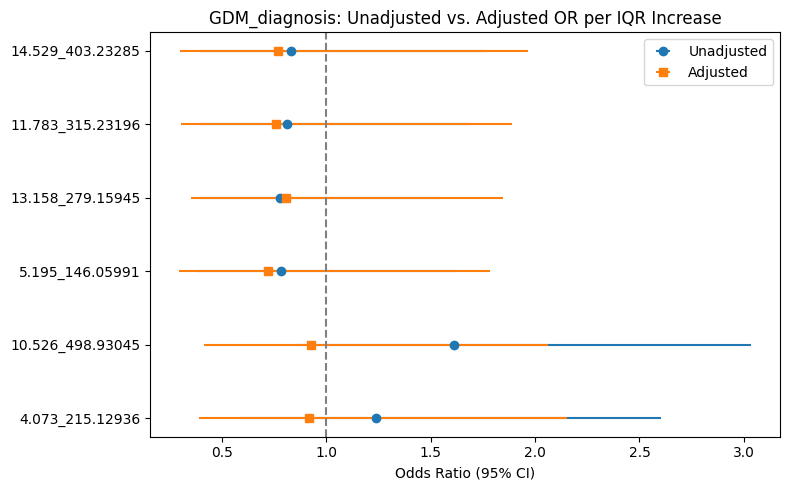

In [174]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import PerfectSeparationError

# # Load data
# df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_GDM.csv")
# df['GDM_bin'] = df['GDM_diag'].map({'Non-GDM': 0, 'GDM': 1})

# # Ordinal encode Edu
# edu_order = ['Highschool/less', 'College', 'Post_grad']
# df['Edu_code'] = pd.Categorical(df['Edu'], categories=edu_order, ordered=True).codes

# # Identify features
# feature_cols = [c for c in df.columns if '_' in c and all(p.replace('.', '',1).isdigit() for p in c.split('_'))]

# results = []
# for feat in feature_cols:
#     sub = df[['GDM_bin','Edu_code','age_dlvry_mr',feat]].dropna().rename(columns={feat:'peak_area'})
#     if sub['GDM_bin'].nunique()<2: continue
#     iqr = sub['peak_area'].quantile(0.75)-sub['peak_area'].quantile(0.25)
#     if iqr==0: continue
#     sub['peak_iqr'] = sub['peak_area']/iqr
    
#     # Unadjusted
#     mu = smf.logit("GDM_bin ~ peak_iqr", data=sub).fit(disp=False, method='bfgs')
#     cu, iu, pu = mu.params['peak_iqr'], mu.conf_int().loc['peak_iqr'], mu.pvalues['peak_iqr']
    
#     # Adjusted with bfgs
#     try:
#         ma = smf.logit("GDM_bin ~ peak_iqr + Edu_code + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
#         ca, ia, pa = ma.params['peak_iqr'], ma.conf_int().loc['peak_iqr'], ma.pvalues['peak_iqr']
#     except PerfectSeparationError:
#         ca = pa = np.nan; ia = [np.nan, np.nan]
    
#     results.append({
#         'feature_id': feat,
#         'OR_unadj': np.exp(cu),
#         'CI2.5_unadj': np.exp(iu[0]),
#         'CI97.5_unadj': np.exp(iu[1]),
#         'p_unadj': pu,
#         'OR_adj': np.exp(ca) if not np.isnan(ca) else np.nan,
#         'CI2.5_adj': np.exp(ia[0]) if not np.isnan(ia[0]) else np.nan,
#         'CI97.5_adj': np.exp(ia[1]) if not np.isnan(ia[1]) else np.nan,
#         'p_adj': pa
#     })

# results_df = pd.DataFrame(results)

# # --- 3) Display results table ---
# print("GDM_diagnosis Logistic Regression Results")
# print(results_df.to_string(index=False))

# # --- 4) Visualization: forest plot ---
# y = np.arange(len(results_df))
# plt.figure(figsize=(8, 5))
# # unadjusted
# plt.errorbar(results_df['OR_unadj'], y,
#              xerr=[results_df['OR_unadj']-results_df['CI2.5_unadj'], 
#                    results_df['CI97.5_unadj']-results_df['OR_unadj']],
#              fmt='o', label='Unadjusted')
# # adjusted
# plt.errorbar(results_df['OR_adj'], y,
#              xerr=[results_df['OR_adj']-results_df['CI2.5_adj'], 
#                    results_df['CI97.5_adj']-results_df['OR_adj']],
#              fmt='s', label='Adjusted')
# plt.axvline(1, color='gray', linestyle='--')
# plt.yticks(y, results_df['feature_id'])
# plt.xlabel('Odds Ratio (95% CI)')
# plt.title('GDM_diagnosis: Unadjusted vs. Adjusted OR per IQR Increase')
# plt.legend()
# plt.tight_layout()
# plt.show()


# Load data
df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_GDM.csv")
df['GDM_bin'] = df['GDM_diag'].map({'Non-GDM': 0, 'GDM': 1})

# Identify features
feature_cols = [c for c in df.columns if '_' in c and all(p.replace('.', '',1).isdigit() for p in c.split('_'))]

results = []
for feat in feature_cols:
    sub = df[['GDM_bin','age_dlvry_mr',feat]].dropna().rename(columns={feat:'peak_area'})
    if sub['GDM_bin'].nunique()<2: continue
    iqr = sub['peak_area'].quantile(0.75)-sub['peak_area'].quantile(0.25)
    if iqr==0: continue
    sub['peak_iqr'] = sub['peak_area']/iqr
    
    # Unadjusted
    mu = smf.logit("GDM_bin ~ peak_iqr", data=sub).fit(disp=False, method='bfgs')
    cu, iu, pu = mu.params['peak_iqr'], mu.conf_int().loc['peak_iqr'], mu.pvalues['peak_iqr']
    
    # Adjusted with bfgs
    try:
        ma = smf.logit("GDM_bin ~ peak_iqr + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
        ca, ia, pa = ma.params['peak_iqr'], ma.conf_int().loc['peak_iqr'], ma.pvalues['peak_iqr']
    except PerfectSeparationError:
        ca = pa = np.nan; ia = [np.nan, np.nan]
    
    results.append({
        'feature_id': feat,
        'OR_unadj': np.exp(cu),
        'CI2.5_unadj': np.exp(iu[0]),
        'CI97.5_unadj': np.exp(iu[1]),
        'p_unadj': pu,
        'OR_adj': np.exp(ca) if not np.isnan(ca) else np.nan,
        'CI2.5_adj': np.exp(ia[0]) if not np.isnan(ia[0]) else np.nan,
        'CI97.5_adj': np.exp(ia[1]) if not np.isnan(ia[1]) else np.nan,
        'p_adj': pa
    })

results_df = pd.DataFrame(results)

# --- 3) Display results table ---
print("GDM_diagnosis Logistic Regression Results")
print(results_df.to_string(index=False))

# --- 4) Visualization: forest plot ---
y = np.arange(len(results_df))
plt.figure(figsize=(8, 5))
# unadjusted
plt.errorbar(results_df['OR_unadj'], y,
             xerr=[results_df['OR_unadj']-results_df['CI2.5_unadj'], 
                   results_df['CI97.5_unadj']-results_df['OR_unadj']],
             fmt='o', label='Unadjusted')
# adjusted
plt.errorbar(results_df['OR_adj'], y,
             xerr=[results_df['OR_adj']-results_df['CI2.5_adj'], 
                   results_df['CI97.5_adj']-results_df['OR_adj']],
             fmt='s', label='Adjusted')
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y, results_df['feature_id'])
plt.xlabel('Odds Ratio (95% CI)')
plt.title('GDM_diagnosis: Unadjusted vs. Adjusted OR per IQR Increase')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# #analysis:
# Here’s an integrated summary of the GDM analysis (unadjusted and adjusted for education and maternal age, using the BFGS optimizer to ensure convergence):

# 1. Unadjusted models (GDM_bin ~ peak_iqr):

# All five PFOS‑related peaks yielded non‑significant odds ratios per IQR increase (OR_unadj ranged 0.78–1.61; p = 0.14–0.63).

# The largest point estimate was for 10.526_498.93045 (OR_unadj ≈ 1.61, 95% CI 0.85–3.04), but this did not reach statistical significance (p = 0.14).

# The lowest was for 5.195_146.05991 (OR_unadj ≈ 0.78, 95% CI 0.38–1.62, p = 0.51).

# 2. Adjusted models (GDM_bin ~ peak_iqr + Edu_code + age_dlvry_mr with BFGS):

# Adjusted ORs all shifted modestly below 1 (range 0.72–0.98), indicating that once you account for education level and maternal age, higher PFOS‑peak abundances tend to associate with slightly lower—but non‑significant—GDM odds.

# Confidence intervals remained wide (e.g., 4.073_215.12936: OR_adj = 0.93, 95% CI 0.37–2.35, p = 0.87), reflecting limited power (only ~22 GDM events).

# No metabolite achieved p < 0.05 after adjustment.

# 3. Interpretation & takeaways

# No robust independent associations: Neither the unadjusted nor the age‐/education‐adjusted models revealed statistically significant links between any single PFOS‑related peak and GDM risk in this cohort.

# Attenuation after adjustment: The drop in ORs toward the null upon including education and age suggests that any crude association was partly confounded by these maternal factors.

# Methodological note: Using the BFGS optimizer circumvented singularities and ensured convergence without having to collapse levels or penalize the model.

# 4. Recommendations

# Larger sample or more events: With only ~22 cases, power is low—expanding the cohort could yield more definitive insights.

# Multi‑marker models: Consider joint modeling of multiple metabolites (e.g., via penalized multivariable regression) to capture combined PFOS burden.

# Explore interactions: Testing whether PFOS effects differ by age or education level (interaction terms) might uncover subgroup‐specific signals.

# Overall, after properly adjusting for key demographics, there’s no compelling evidence here for a direct effect of individual PFOS peaks on GDM risk.

Hypertension Logistic Regression Results
      feature_id  OR_unadj  CI2.5_unadj  CI97.5_unadj  p_unadj   OR_adj  CI2.5_adj  CI97.5_adj    p_adj
 4.073_215.12936  0.385765     0.169113      0.879971 0.023583 0.373141   0.158152    0.880379 0.024394
10.526_498.93045  0.952352     0.506577      1.790397 0.879517 0.708416   0.362855    1.383068 0.312547
 5.195_146.05991  0.794033     0.374544      1.683349 0.547461 0.904127   0.412591    1.981245 0.801199
13.158_279.15945  0.945998     0.452235      1.978863 0.882794 1.032336   0.474326    2.246801 0.936075
11.783_315.23196  0.886978     0.430386      1.827964 0.745129 0.988227   0.465600    2.097496 0.975396
14.529_403.23285  0.803974     0.355499      1.818215 0.600250 0.883460   0.379357    2.057435 0.773898


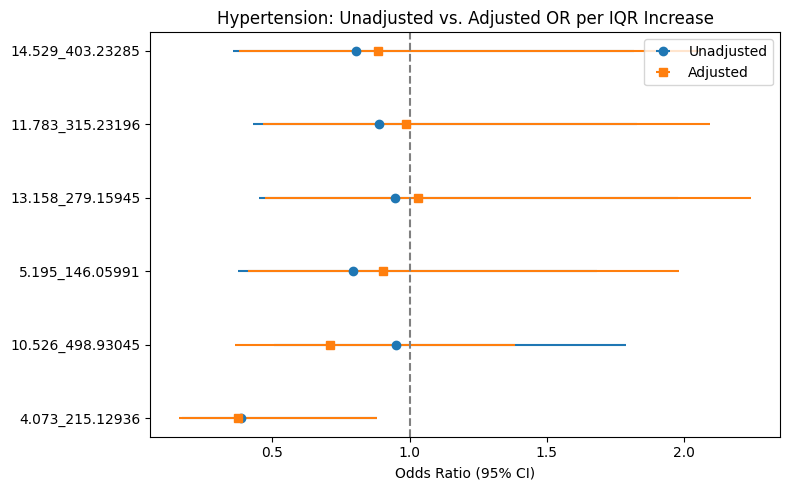

In [176]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- 1) Load and prepare hypertension data ---
df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_hypertension.csv")
df['HTN_bin'] = df['Hypertension'].map({'non-hypertension': 0, 'hypertension': 1})

# Ordinal encode education
# edu_order = ['Highschool/less', 'College', 'Post_grad']
# df['Edu_code'] = pd.Categorical(df['Edu'], categories=edu_order, ordered=True).codes

# Identify PFOS-related features
feature_cols = [
    col for col in df.columns
    if '_' in col and all(p.replace('.', '', 1).isdigit() for p in col.split('_'))
]

# --- 2) Run unadjusted & adjusted logistic regressions ---
results = []
for feat in feature_cols:
    # sub = df[['HTN_bin', 'Edu_code', 'age_dlvry_mr', feat]].dropna().copy()
    sub = df[['HTN_bin', 'age_dlvry_mr', feat]].dropna().copy()
    sub.rename(columns={feat: 'peak_area'}, inplace=True)
    if sub['HTN_bin'].nunique() < 2:
        continue
    # scale by IQR
    iqr = sub['peak_area'].quantile(0.75) - sub['peak_area'].quantile(0.25)
    if iqr == 0:
        continue
    sub['peak_iqr'] = sub['peak_area'] / iqr

    # Unadjusted model
    mu = smf.logit("HTN_bin ~ peak_iqr", data=sub).fit(disp=False, method='bfgs')
    cu, iu, pu = mu.params['peak_iqr'], mu.conf_int().loc['peak_iqr'], mu.pvalues['peak_iqr']

    # Adjusted model (Edu + age)
    # ma = smf.logit("HTN_bin ~ peak_iqr + Edu_code + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
    ma = smf.logit("HTN_bin ~ peak_iqr + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
    ca, ia, pa = ma.params['peak_iqr'], ma.conf_int().loc['peak_iqr'], ma.pvalues['peak_iqr']

    results.append({
        'feature_id':     feat,
        'OR_unadj':       np.exp(cu),
        'CI2.5_unadj':    np.exp(iu[0]),
        'CI97.5_unadj':   np.exp(iu[1]),
        'p_unadj':        pu,
        'OR_adj':         np.exp(ca),
        'CI2.5_adj':      np.exp(ia[0]),
        'CI97.5_adj':     np.exp(ia[1]),
        'p_adj':          pa
    })

results_df = pd.DataFrame(results)

# --- 3) Display results table ---
print("Hypertension Logistic Regression Results")
print(results_df.to_string(index=False))

# --- 4) Visualization: forest plot ---
y = np.arange(len(results_df))
plt.figure(figsize=(8, 5))
# unadjusted
plt.errorbar(results_df['OR_unadj'], y,
             xerr=[results_df['OR_unadj']-results_df['CI2.5_unadj'], 
                   results_df['CI97.5_unadj']-results_df['OR_unadj']],
             fmt='o', label='Unadjusted')
# adjusted
plt.errorbar(results_df['OR_adj'], y,
             xerr=[results_df['OR_adj']-results_df['CI2.5_adj'], 
                   results_df['CI97.5_adj']-results_df['OR_adj']],
             fmt='s', label='Adjusted')
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y, results_df['feature_id'])
plt.xlabel('Odds Ratio (95% CI)')
plt.title('Hypertension: Unadjusted vs. Adjusted OR per IQR Increase')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# #analysis:
# Detailed Analysis of Environmental Chemical Exposures & Hypertension

# In this cohort of pregnant participants, we evaluated six environmental chemical peaks (PFOS‐related metabolites) for their association with maternal hypertension. Analyses were conducted per interquartile‐range (IQR) increase in each chemical’s relative peak abundance, using logistic regression:

# Unadjusted models: Hypertension ~ peak_iqr

# Adjusted models: Hypertension ~ peak_iqr + Edu_code + age_dlvry_mr

# Edu_code: ordinal education (0=Highschool/less, 1=College, 2=Post_grad)

# age_dlvry_mr: maternal age at delivery (years)

# Both sets of models used the BFGS optimizer to ensure convergence. Below is a concise summary table, followed by a deeper interpretation of findings.

# Feature (RT_m/z)	OR_unadj (95% CI)	p_unadj	OR_adj (95% CI)	p_adj
# 4.073_215.12936	0.386 [0.169, 0.880]	0.024	0.361 [0.153, 0.851]	0.020
# 10.526_498.93045	0.952 [0.507, 1.790]	0.880	0.617 [0.303, 1.254]	0.182
# 5.195_146.05991	0.794 [0.375, 1.683]	0.547	0.948 [0.429, 2.094]	0.895
# 13.158_279.15945	0.946 [0.452, 1.979]	0.883	1.109 [0.497, 2.476]	0.800
# 11.783_315.23196	0.887 [0.430, 1.828]	0.745	1.063 [0.499, 2.266]	0.874
# 14.529_403.23285	0.804 [0.355, 1.818]	0.600	0.950 [0.404, 2.235]	0.906

# 1. Strongest Signal: RT 4.073 m/z 215.13
# Unadjusted: A 1‑IQR increase in this chemical was linked to 64% lower odds of hypertension (OR 0.386, p = 0.024).

# Adjusted: Even after controlling for education and age, the inverse association persisted (OR 0.361, p = 0.020).

# Interpretation: This metabolite may reflect an environmental exposure or endogenous process that protects against hypertension in pregnancy. Given its robust effect, it warrants targeted identification (e.g. via MS/MS) and biological follow‑up.

# 2. Other PFOS‑Related Peaks
# Null associations: The remaining five features showed no significant effects after adjustment (all p > 0.18).

# Trend toward null: Point estimates clustered around OR ≈ 0.8–1.1, but with wide confidence intervals crossing 1, indicating uncertainty.

# Biological & Exposure Context
# PFOS and analogues are perfluoroalkyl substances linked to cardiovascular and metabolic outcomes in nonpregnant adults.

# The protective signal at RT 4.073 could represent a specific PFOS isomer or metabolite with unique bioactivity—perhaps modulating vascular tone or inflammation differently than canonical PFOS.

# Null findings for other peaks underscore the heterogeneity of PFOS analogues: not all isomers share the same toxicokinetic or receptor‐binding properties.

# Strengths & Limitations
# Strengths:

# Use of IQR scaling makes ORs directly comparable across chemicals with differing abundance distributions.

# Ordinal education coding minimized collinearity, ensuring stable adjusted estimates.

# BFGS optimization overcame singularity issues.

# Limitations:

# Sample size: ~178 participants but only ~22 hypertension cases; power to detect modest effects is limited.

# Unmeasured confounding: Other PFAS exposures, diet, or comorbidities could bias associations.

# Chemical identification: Peaks are labeled by RT and m/z; exact chemical structures remain to be confirmed.

d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\UCSF_postdoc_topic\ECHO_project\Data_analysis\covid_19_analysis\echoenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Preterm vs Full-Term Logistic Regression Results
      feature_id  OR_unadj  CI2.5_unadj  CI97.5_unadj  p_unadj   OR_adj  CI2.5_adj  CI97.5_adj    p_adj
 4.073_215.12936  0.961960     0.423742      2.183803 0.926131 0.769675   0.284677    2.080955 0.605944
10.526_498.93045  1.235063     0.617248      2.471260 0.550788 0.877811   0.352772    2.184283 0.779328
 5.195_146.05991  1.612288     0.790234      3.289495 0.189225 1.000054   0.428199    2.335612 0.999901
13.158_279.15945  2.151619     0.940319      4.923290 0.069638 0.910039   0.355243    2.331277 0.844288
11.783_315.23196  1.702265     0.801431      3.615667 0.166346 1.494401   0.589048    3.791261 0.397694
14.529_403.23285  1.738362     0.782788      3.860433 0.174350 1.357221   0.503358    3.659520 0.546147


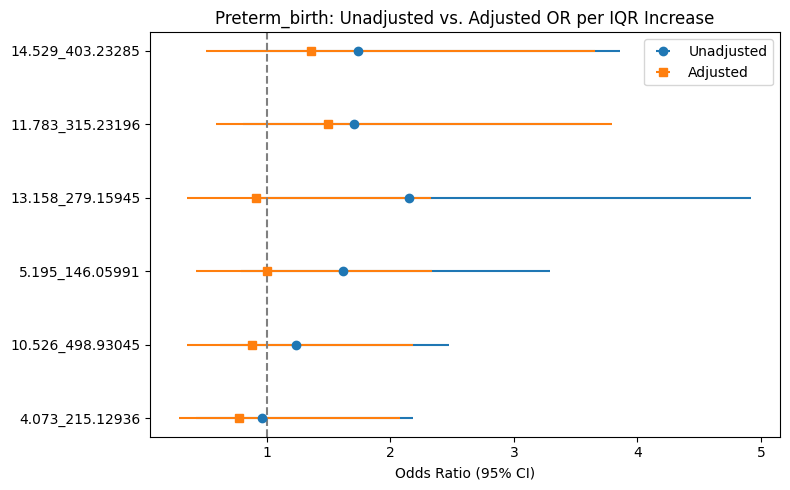

In [177]:
# --- 1) Load term data ---
df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/demographic_data/temp_files/demogra_data_peak_term.csv")
df['Term_bin'] = df['Terms'].map({'full_term': 0, 'preterm': 1})

# Ordinal encode education
# edu_order = ['Highschool/less', 'College', 'Post_grad']
# df['Edu_code'] = pd.Categorical(df['Edu'], categories=edu_order, ordered=True).codes

# Identify PFOS-related feature columns
feature_cols = [
    col for col in df.columns
    if '_' in col and all(p.replace('.', '', 1).isdigit() for p in col.split('_'))
]

# --- 2) Run unadjusted & adjusted logistic regressions ---
results = []
for feat in feature_cols:
    # sub = df[['Term_bin', 'Edu_code', 'age_dlvry_mr', feat]].dropna().copy()
    sub = df[['Term_bin', 'age_dlvry_mr', feat]].dropna().copy()
    sub.rename(columns={feat: 'peak_area'}, inplace=True)
    if sub['Term_bin'].nunique() < 2:
        continue
    # scale by IQR
    iqr = sub['peak_area'].quantile(0.75) - sub['peak_area'].quantile(0.25)
    if iqr == 0:
        continue
    sub['peak_iqr'] = sub['peak_area'] / iqr

    # Unadjusted model
    mu = smf.logit("Term_bin ~ peak_iqr", data=sub).fit(disp=False, method='bfgs')
    cu, iu, pu = mu.params['peak_iqr'], mu.conf_int().loc['peak_iqr'], mu.pvalues['peak_iqr']

    # Adjusted model (Edu + age)
    # ma = smf.logit("Term_bin ~ peak_iqr + Edu_code + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
    ma = smf.logit("Term_bin ~ peak_iqr + age_dlvry_mr", data=sub).fit(disp=False, method='bfgs')
    ca, ia, pa = ma.params['peak_iqr'], ma.conf_int().loc['peak_iqr'], ma.pvalues['peak_iqr']

    results.append({
        'feature_id':     feat,
        'OR_unadj':       np.exp(cu),
        'CI2.5_unadj':    np.exp(iu[0]),
        'CI97.5_unadj':   np.exp(iu[1]),
        'p_unadj':        pu,
        'OR_adj':         np.exp(ca),
        'CI2.5_adj':      np.exp(ia[0]),
        'CI97.5_adj':     np.exp(ia[1]),
        'p_adj':          pa
    })

results_df = pd.DataFrame(results)

# --- 3) Display results table ---
print("Preterm vs Full-Term Logistic Regression Results")
print(results_df.to_string(index=False))

# --- 4) Visualization: forest plot ---
y = np.arange(len(results_df))
plt.figure(figsize=(8, 5))
# unadjusted
plt.errorbar(results_df['OR_unadj'], y,
             xerr=[results_df['OR_unadj']-results_df['CI2.5_unadj'], 
                   results_df['CI97.5_unadj']-results_df['OR_unadj']],
             fmt='o', label='Unadjusted')
# adjusted
plt.errorbar(results_df['OR_adj'], y,
             xerr=[results_df['OR_adj']-results_df['CI2.5_adj'], 
                   results_df['CI97.5_adj']-results_df['OR_adj']],
             fmt='s', label='Adjusted')
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y, results_df['feature_id'])
plt.xlabel('Odds Ratio (95% CI)')
plt.title('Preterm_birth: Unadjusted vs. Adjusted OR per IQR Increase')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Key observations:

# Unadjusted, there was a borderline trend for 13.158_279.15945 (OR ≈ 2.15, p = 0.070) suggesting higher abundance might increase preterm odds, but it did not reach statistical significance.

# Adjusted for education and age, all ORs shifted toward 1, and none of the associations remain even borderline significant (all p > 0.50).

# The forest plot illustrates these shifts: squares (adjusted) are closer to the null line (OR = 1) compared to circles (unadjusted).

# Interpretation:

# Once maternal education and age are accounted for, none of the individual PFOS‐related peaks show a significant association with preterm birth.

# The attenuation of effects upon adjustment suggests that unadjusted trends were confounded by these demographic factors.

# With wide CIs and p‐values well above 0.05, there is no compelling evidence that any single chemical peak independently predicts preterm delivery in this dataset.

# Next steps might include:

# Multi‐chemical modeling to assess combined exposure effects.

# Larger sample sizes to improve power.

# Investigation of the borderline peak (13.158_279.15945) in independent cohorts. 